<a href="https://colab.research.google.com/github/Thirvin/DS_HW02/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-cloud-logging
!pip install google-cloud-monitoring

In [ ]:
!gcloud auth login
!gcloud auth application-default login
!gcloud auth application-default set-quota-project tsmccareerhack2024-icsd-grp6
!gcloud config set project tsmccareerhack2024-icsd-grp6

In [ ]:
!gcloud config set project tsmccareerhack2024-icsd-grp6
!gcloud config set run/region us-central1

Updated property [core/project].
Updated property [run/region].


In [ ]:
from datetime import datetime, timedelta, timezone

def convert_time_format(time_str):
  # 清除空白
  time_str = time_str.strip()
  # 轉換日期格式
  dt = datetime.strptime(time_str, '%a %b %d %Y %H:%M:%S').replace(tzinfo=timezone.utc) - timedelta(hours = 8)
  # dt = dt.strftime('%Y-%m-%d %H:%M')
  return dt
  # dt = dt.replace(tzinfo=pytz.utc)
  # return dt.isoformat()

def create_dict(row):
  return {
  '1xx': row['Request Count (1xx)'],
  '2xx': row['Request Count (2xx)'],
  '3xx': row['Request Count (3xx)'],
  '4xx': row['Request Count (4xx)']
  }

def data_preprocessing(file_name):
  df = pd.read_csv(file_name +'.csv')
  df.rename(columns={'Time': 'time'}, inplace=True)
  # 修改time
  df['time'] = df['time'].apply(convert_time_format)
  if df.shape[1] > 2:
    if df.shape[1] == 3:
        active_col = [col for col in df.columns if 'active' in col]
        df['data'] = df[active_col]
    else:
        df['data'] = df.apply(create_dict, axis=1)
  else:
    data_col = df.columns.drop('time')[0]
    if '%' in data_col:
      df['data'] = df[data_col] / 100
    else:
      df['data'] = df[data_col]

  df = df[['data','time']]
  return df

In [ ]:
# @title DataBases

from google.cloud import logging
from google.protobuf.timestamp_pb2 import Timestamp
import pandas as pd
from datetime import datetime, timedelta, timezone
from google.cloud.logging import DESCENDING
from google.cloud import monitoring_v3

class Datas:
  def __init__(self, project_id_, service_name_, mode = 0):
    self.dir = {}
    self.ratio = ["memory_utilization","CPU_utilization"]

    self.targets = ['memory_utilization','latency','CPU_utilization','VM_counts']
    self.dir['memory_utilization'] = 'container/memory/utilizations'
    self.dir['latency'] = 'request_latencies'
    self.dir['CPU_utilization'] = 'container/cpu/utilizations'
    self.dir['VM_counts'] = 'container/instance_count'
    self.project_id = project_id_
    self.service_name = service_name_
    self.track_hours = 30
    self.metrics = {}
    if mode == 1:
      self.df_keys = ['CPU_utilization','memory_utilization','latency','VM_counts','req_counts','req_latency']
      self.files = ['/content/drive/MyDrive/tsmc/sample/Container_CPU_Utilization','/content/drive/MyDrive/tsmc/sample/Container_Memory_Utilization','/content/drive/MyDrive/tsmc/sample/Request_Latency','/content/drive/MyDrive/tsmc/sample/Instance_Count','/content/drive/MyDrive/tsmc/sample/Request_Count','/content/drive/MyDrive/tsmc/sample/Request_Latency']
      for k, fn in zip(self.df_keys, self.files):
        self.metrics[k] = data_preprocessing(fn)
    else:
      for i in self.targets:
        self.metrics[i] = self.query_metric_data(i,60*self.track_hours)
    self.log = self.query_cloud_run_logs()




  def query_metric_data(self, target, duration_minutes=1):
    client = monitoring_v3.MetricServiceClient()
    project_name = f"projects/{self.project_id}"

    # Get current time in RFC 3339 format
    end_time = Timestamp()
    end_time.GetCurrentTime()
    end_time_str = datetime.utcfromtimestamp(end_time.seconds).isoformat() + "Z"

    # Set the start time by subtracting the duration from the end time
    start_time = Timestamp()
    start_time.FromDatetime(end_time.ToDatetime() - timedelta(minutes=duration_minutes))
    start_time_str = datetime.utcfromtimestamp(start_time.seconds).isoformat() + "Z"

    interval = monitoring_v3.TimeInterval(
        {
            "end_time": end_time_str,
            "start_time": start_time_str,
        }
    )

    # Build the filter string for the metric
    filter_str = f'resource.type="cloud_run_revision" AND resource.labels.service_name="{self.service_name}" AND metric.type="run.googleapis.com/{self.dir[target]}"'

    # Build the request
    request = monitoring_v3.ListTimeSeriesRequest(
        name=project_name,
        filter=filter_str,
        interval=interval,
        view=monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL
    )

    response = client.list_time_series(request)

    data = {}

    if response.time_series:
        for ts in response.time_series:
            for point in ts.points:
                timestamp = point.interval.start_time
                if timestamp not in data or point.value.distribution_value.mean > data[timestamp]['data']:
                    data[timestamp] = {
                        'data': point.value.distribution_value.mean,
                        'time': timestamp,
                    }

    result_data = list(data.values())
    result_data.sort(key=lambda x: x['time'])

    return pd.DataFrame(result_data)

# Assuming the rest of the code has the necessary setup and the class method is part of a class.


# Assuming the rest of the code has the necessary setup and the class method is part of a class.


# Assuming the rest of the code has the necessary setup and the class method is part of a class.

  def query_cloud_run_logs(self,end_time = datetime.utcnow(),duration_hour = 60):
    project_name = f"{self.project_id}"
    logging_client = logging.Client(project = project_name)

    start_time = end_time - timedelta(hours=duration_hour)


    start_time_str = start_time.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'
    end_time_str = end_time.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'

    # Build the filter string for Cloud Run logs
    FILTER = f'resource.type="cloud_run_revision" AND resource.labels.service_name="{self.service_name}"  AND Severity >= "ERROR"'

    # Make the API call

    entries = logging_client.list_entries(
        filter_=f'{FILTER} AND timestamp >= "{start_time_str}" AND timestamp <= "{end_time_str}"',
        order_by="timestamp desc",
    )

    logs = []
    for entry in entries:
      tmp = {}
      tmp['data'] = entry.payload['status']['message'];
      tmp['time'] = entry.timestamp
      logs.append(tmp)
    logs.reverse()

    return pd.DataFrame(logs)

  def update(self):

      new_log_row = self.query_cloud_run_logs(datetime.utcnow(),1/60)
      self.log = pd.concat([self.log,new_log_row])
      self.log = self.log.reset_index(drop=True)



      for i in self.targets:
        print(i)
        new_metrics_row = self.query_metric_data(i,1)

        self.metrics[i] = self.metrics[i].drop([0])
        self.metrics[i] = pd.concat([self.metrics[i],pd.DataFrame(new_metrics_row)])
        self.metrics[i] = self.metrics[i].reset_index(drop=True)




In [ ]:
tmp_data = Datas('tsmccareerhack2024-icsd-grp6','nginx',0)

In [ ]:
tmp_data.metrics

{'memory_utilization':           data                             time
 0     0.030273 2024-01-25 10:15:35.580000+00:00
 1     0.030273 2024-01-25 10:16:35.580000+00:00
 2     0.030273 2024-01-25 10:17:35.580000+00:00
 3     0.030273 2024-01-25 10:18:35.580000+00:00
 4     0.030273 2024-01-25 10:19:35.580000+00:00
 ...        ...                              ...
 1791  0.117462 2024-01-26 16:09:35.580000+00:00
 1792  0.117462 2024-01-26 16:10:35.580000+00:00
 1793  0.117462 2024-01-26 16:11:35.580000+00:00
 1794  0.117462 2024-01-26 16:12:35.580000+00:00
 1795  0.117462 2024-01-26 16:13:35.580000+00:00
 
 [1796 rows x 2 columns],
 'latency':       data                             time
 0      0.0 2024-01-25 10:15:04.911000+00:00
 1      0.0 2024-01-25 10:16:04.911000+00:00
 2      0.0 2024-01-25 10:17:04.911000+00:00
 3      0.0 2024-01-25 10:18:04.911000+00:00
 4      0.0 2024-01-25 10:19:04.911000+00:00
 ...    ...                              ...
 1642   0.0 2024-01-26 13:39:04.9110

In [ ]:
tmp_data.log

,data,time
0,spec.template.spec.containers[0].resources.lim...,2024-01-26 06:42:35.277620+00:00
1,spec.template.spec.containers[0].resources.lim...,2024-01-26 06:42:44.409953+00:00
2,spec.template.spec.containers[0].resources.lim...,2024-01-26 06:42:53.958317+00:00
3,spec.template.spec.containers[0].resources.lim...,2024-01-26 06:43:03.557466+00:00
4,spec.template.spec.containers[0].resources.lim...,2024-01-26 06:43:13.486583+00:00
5,spec.template.spec.containers[0].resources.lim...,2024-01-26 06:43:41.421706+00:00
6,spec.template.spec.containers[0].resources.lim...,2024-01-26 06:43:50.868002+00:00
7,spec.template.spec.containers[0].resources.lim...,2024-01-26 06:44:00.584828+00:00
8,spec.template.spec.containers[0].resources.lim...,2024-01-26 06:46:21.608910+00:00
9,spec.template.spec.containers[0].resources.lim...,2024-01-26 06:49:55.202400+00:00


In [ ]:
import json
import re
import matplotlib.pyplot as plt
import vertexai
from vertexai.language_models import TextGenerationModel
class vertexai_model :
  def __init__(self):
    self.image_buf = []
    self.upper_threshold = 10
    self.lower_threshold = 5
    vertexai.init(project="tsmccareerhack2024-icsd-grp6", location="us-central1")
    self.model1 = TextGenerationModel.from_pretrained("text-bison@001")
    self.parameters = {
    "candidate_count": 1,
    "max_output_tokens": 1024,
    "temperature": 0.7,
    "top_p": 1
    }
    self.data = tmp_data
    for i in range(len(self.data.log)):
      self.data.log['data'][i] = self.reduce_log(self.data.log['data'][i])

  def reduce_log(self,log):
    prompt = f'''I am log reader. after reading a log I have to extract key message from log. now given 1 log and shorten the log and remain the important messages in 1 line for the log:
log:
"{log}"
'''
    response = self.model1.predict(prompt,**self.parameters)
    return response.text

  def transform_question(self, question):
    prompt = f"""Task: Convert the following question into a better format to make it clear, concise, and grammatically correct for submission to LLM.
Pay attention to the order of time, and use absolute times rather than relative times, such as yesterday, today, this morning.

Question:
Current time is {datetime.now().strftime('%Y-%m-%d %H:%M')}.
{question}
Output:
"""
    print(prompt)
    response = self.model1.predict(prompt,**self.parameters)
    return response.text

  def ask_data(self, question):
    prompt =  """The following is a question which need a interval data tell me the interval of time and the type of required only including CPU utilization, memory utilization, latency, VM_counts and logs in following format:

Input:
Can you tell me the memory utilization for the last 30 hours?
Output:
memory_utilization,2024-01-23 08:35,2024-01-24 14:35

Input:
What is the CPU utilization and latency yesterday?
Output:
CPU_utilization,2024-01-23 00:00,2024-01-24 23:59
latency,2024-01-23 00:00,2024-01-23 23:59

Intput:
Any error at 4pm to 5pm at 2024 01/27?
Output:
memory_utilizatoin,2024-01-27 16:00,2024-01-27 17:00
VM_counts,2024-01-27 16:00,2024-01-27 17:00
CPU_utilization,2024-01-27 16:00,2024-01-27 17:00
latency,2024-01-27 16:00,2024-01-27 17:00
logs,2024-01-27 16:00,2024-01-27 17:00

Input:
"""
    prompt = prompt + question + "\nOutput:\n"

    response = self.model1.predict(prompt,**self.parameters)
    response = response.text

    datas = response.split("\n")
    ret = {}
    print(datas)
    for data in datas:
      try:
        data = data.split(",")
        ret[data[0].replace(" ","")] = []
        ret[data[0].replace(" ","")].append(data[1])
        ret[data[0].replace(" ","")].append(data[2])
      except:
        return "Error"
    return ret

  '''
  def ask_data_type(self, question):
    prompt = """I am a database manager. I will recieve a question and in order to answer it I have to tell the database if the metrics(including cpu utilization, memory utilization, latency and vm counts) or logs(includes error logs or warning logs) are needed
    input:
    How's the server today ?
    output:
    metrics
    logs

    input:
    what's the cpu utilization yesterday ?
    output:
    metrics

    input:
    My server just shutdown is there any error ?
    output:
    logs
    input:
    """
    prompt = prompt + question + "\noutput:\n"
    response = self.model1.predict(prompt, **self.parameters)
    return response.text
  '''

  def to_image(self,data_y,title):
    data_x = [i for i in range(len(data_y))]
    plt.figure()
    plt.plot(data_x,data_y, label='Data')
    plt.xlabel('Time (unit: minutes)')
    plt.ylabel('Data')
    plt.title(title)
    plt.legend()

    # Saving the plot to a file
    plot_file_path = title+'.png'
    self.image_buf.append(plot_file_path)
    plt.savefig(plot_file_path)

  def ask_question(self, question):
    question = self.transform_question(question)
    required_data = self.ask_data(question)
    print(required_data)
    prompt = "You are a system maintainer. Someone asked you a question then you have to use data to answer the question\nquestion and eplain the question then give a solution:\n"
    prompt += question + '\n'
    print(prompt)

    data_text = ''
    log_text = ''

    for key in required_data.keys():

      data_y = []
      prompt += "time:" + str(datetime.strptime(required_data[key][0], '%Y-%m-%d %H:%M').replace(tzinfo=timezone.utc)) + " to " + str(datetime.strptime(required_data[key][1], '%Y-%m-%d %H:%M').replace(tzinfo=timezone.utc))
      if key != 'log':
        prompt += " time step : 1 min"
      prompt += '\n'
      start_time = datetime.strptime(required_data[key][0], '%Y-%m-%d %H:%M').replace(tzinfo=timezone.utc) - timedelta(hours = 8)
      end_time = datetime.strptime(required_data[key][1], '%Y-%m-%d %H:%M').replace(tzinfo=timezone.utc) - timedelta(hours = 8)
      print(start_time, end_time)
      if key == 'logs':
        log_text += key + ": [\n"
        first = 1
        for row in self.data.log[::-1].itertuples():
          if start_time <= row[2] and row[2] <= end_time:
            if  first != 1:
              log_text += ',\n'
            else:
              first = 0
            log_text += "'" + str(row[1]) + "'"
        log_text += ']\n'

      else:
        data_text += key.replace('_', ' ') + ": ["
        first = 1
        for row in self.data.metrics[key][::-1].itertuples():
          if start_time <= row[2] and row[2] <= end_time:
            if first != 1:
              data_text += ', '
            else:
              first = 0
            if key in self.data.ratio:
              data_text += str(row[1]*100)[:3] + "%"
              data_y.append(row[1]*100)
            else:
              data_text += str(row[1])
              data_y.append((row[1]))
        data_text += ']\n'
        self.to_image(data_y,key)

    print(prompt + log_text + data_text)
    response = self.model1.predict(prompt + log_text + data_text, **self.parameters)
    return response.text

  def scaling(self):

    vm_info = !gcloud run services describe nginx --format=json
    vm_info = json.loads(''.join(vm_info))

    try:
      vm_CPU = int(vm_info['spec']['template']['spec']['containers'][0]['resources']['limits']['cpu'])
    except:
      vm_CPU = 1

    vm_memory = vm_info['spec']['template']['spec']['containers'][0]['resources']['limits']['memory']
    if vm_memory[-2:] == 'Gi':
      vm_memory = str(int(re.findall(r'\d+', vm_memory)[0]) * 1024) + 'Mi'

    cpu_utilizations = [round(self.data.metrics['CPU_utilization']['data'].iloc[-1] * 100, 2), round(self.data.metrics['CPU_utilization']['data'].iloc[-2] * 100, 2)]
    memory_utilizations = [round(self.data.metrics['memory_utilization']['data'].iloc[-1] * 100, 2), round(self.data.metrics['memory_utilization']['data'].iloc[-2] * 100, 2)]

    if cpu_utilizations[0] > self.upper_threshold and cpu_utilizations[1] > self.upper_threshold:
      if vm_CPU == 1:
        new_vm_CPU = 2
      else:
        new_vm_CPU = min(vm_CPU + 2, 8)
      if new_vm_CPU != vm_CPU:
        !gcloud run services update nginx --cpu $new_vm_CPU

    elif cpu_utilizations[0] < self.lower_threshold and cpu_utilizations[1] < self.lower_threshold:
      if vm_CPU != 1:
        new_vm_CPU = max(vm_CPU - 2, 1)
      else:
        new_vm_CPU = 1
      if new_vm_CPU != vm_CPU:
        !gcloud run services update nginx --cpu $new_vm_CPU

    if memory_utilizations[0] > self.upper_threshold and memory_utilizations[1] > self.upper_threshold:
      vm_memory = str(int(re.findall(r'\d+', vm_memory)[0]) // 2) + vm_memory[-2:]
      !gcloud run services update nginx --memory $vm_memory
    elif memory_utilizations[0] < self.lower_threshold and memory_utilizations[1] < self.lower_threshold:
      vm_memory = str(int(re.findall(r'\d+', vm_memory)[0]) * 2) + vm_memory[-2:]
      !gcloud run services update nginx --memory $vm_memory

In [ ]:
Model = vertexai_model()

<ipython-input-327-628cd33ad314>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.log['data'][i] = self.reduce_log(self.data.log['data'][i])


In [ ]:
Model.transform_question('Can you tell me the memory utilization for the previous 30 hours?')

'Given the time is 2024-05-26 19:05, please provide the memory utilization for the previous 30 hours.'

In [ ]:
Model.ask_data('Given the time is 2024-05-26 19:05, please provide the memory utilization for the previous 30 hours.')

['memory_utilization,2024-05-26 09:05,2024-05-27 19:05']


{'memory_utilization': ['2024-05-26 09:05', '2024-05-27 19:05']}

In [ ]:
print(Model.data.log['data'][0])

Container has invalid memory limit.


In [ ]:
Model.data.metrics

{'memory_utilization':           data                             time
 0     0.030273 2024-01-25 10:15:35.580000+00:00
 1     0.030273 2024-01-25 10:16:35.580000+00:00
 2     0.030273 2024-01-25 10:17:35.580000+00:00
 3     0.030273 2024-01-25 10:18:35.580000+00:00
 4     0.030273 2024-01-25 10:19:35.580000+00:00
 ...        ...                              ...
 1791  0.117462 2024-01-26 16:09:35.580000+00:00
 1792  0.117462 2024-01-26 16:10:35.580000+00:00
 1793  0.117462 2024-01-26 16:11:35.580000+00:00
 1794  0.117462 2024-01-26 16:12:35.580000+00:00
 1795  0.117462 2024-01-26 16:13:35.580000+00:00
 
 [1796 rows x 2 columns],
 'latency':       data                             time
 0      0.0 2024-01-25 10:15:04.911000+00:00
 1      0.0 2024-01-25 10:16:04.911000+00:00
 2      0.0 2024-01-25 10:17:04.911000+00:00
 3      0.0 2024-01-25 10:18:04.911000+00:00
 4      0.0 2024-01-25 10:19:04.911000+00:00
 ...    ...                              ...
 1642   0.0 2024-01-26 13:39:04.9110

In [ ]:
Model.ask_data("Does theere has any problem in server 10:00 AM to 4:00 PM in 2023 12/7?")

['logs,2023-12-07 10:00,2023-12-07 16:00']


{'logs': ['2023-12-07 10:00', '2023-12-07 16:00']}

['VM_counts,2024-01-26 14:00,2024-01-26 15:00', 'CPU_utilization,2024-01-26 14:00,2024-01-26 15:00', 'latency,2024-01-26 14:00,2024-01-26 15:00']
{'VM_counts': ['2024-01-26 14:00', '2024-01-26 15:00'], 'CPU_utilization': ['2024-01-26 14:00', '2024-01-26 15:00'], 'latency': ['2024-01-26 14:00', '2024-01-26 15:00']}
You are a system maintainer. Someone asked you a question then you have to use data to answer the question
question and eplain the question then give a solution:
What was the status of servers from 14am to 15am on 01/26/2024?

2024-01-26 06:00:00+00:00 2024-01-26 07:00:00+00:00


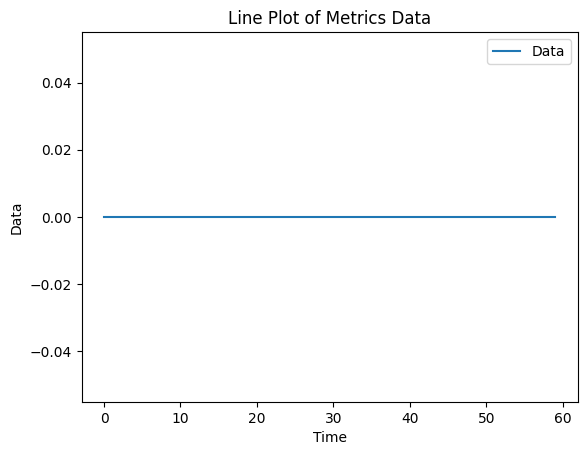

2024-01-26 06:00:00+00:00 2024-01-26 07:00:00+00:00


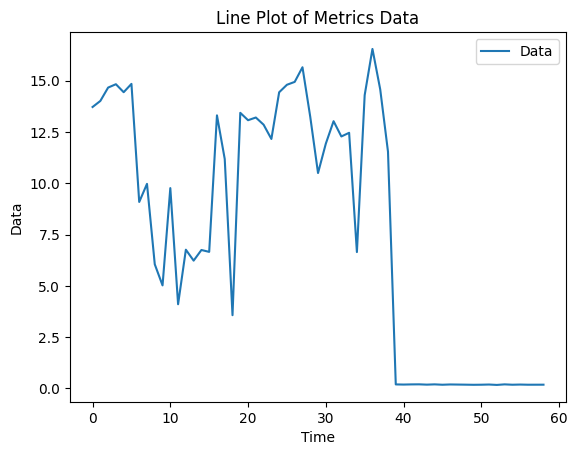

2024-01-26 06:00:00+00:00 2024-01-26 07:00:00+00:00


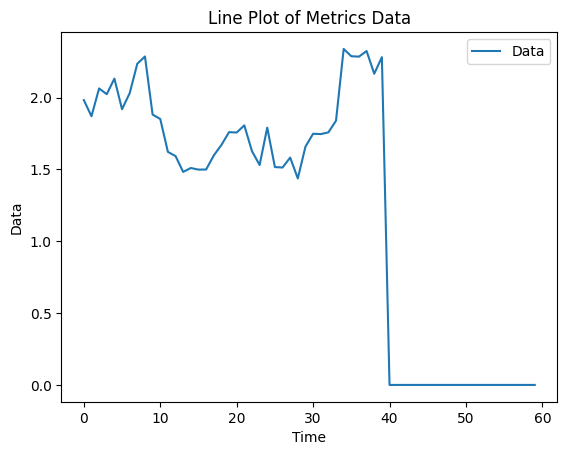

You are a system maintainer. Someone asked you a question then you have to use data to answer the question
question and eplain the question then give a solution:
What was the status of servers from 14am to 15am on 01/26/2024?
time:2024-01-26 14:00:00+00:00 to 2024-01-26 15:00:00+00:00 time step : 1 min
time:2024-01-26 14:00:00+00:00 to 2024-01-26 15:00:00+00:00 time step : 1 min
time:2024-01-26 14:00:00+00:00 to 2024-01-26 15:00:00+00:00 time step : 1 min
VM counts: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CPU utilization: [13.%, 14.%, 14.%, 14.%, 14.%, 14.%, 9.0%, 9.9%, 6.0%, 5.0%, 9.7%, 4.1%, 6.7%, 6.2%, 6.7%, 6.6%, 13.%, 11.%, 3.5%, 13.%, 13.%, 13.%, 12.%, 12.%, 14.%, 14.%, 14.%, 15.%, 13.%, 10.%, 11.%, 13.%, 12.%, 12.%, 6.6%, 

'The data shows that the servers were busy during this time period. The CPU utilization was high and the latency was also high. This could be due to a number of factors, such as an increase in traffic or a decrease in the number of servers available. It is important to monitor the servers closely to ensure that they are able to handle the load.'

In [ ]:
Model.ask_question("what is status of server 14am to 15am 2024 01/26 ?")

In [ ]:
print(Model.ask_data_type("anything error in my internet?"))

 logs


In [ ]:
print(Model.ask_question("any problem with Memory or CPU utilization between 10:00 AM and 4:00 PM in 2024 1/26 ?"))

['CPU_utilization,2024-01-26 10:00,2024-01-26 16:00', 'memory_utilization,2024-01-26 10:00,2024-01-26 16:00', '    input:', 'Did we have any downtime between Monday and Friday last week?', '    output:', 'logs,2024-01-17 00:00,2024-01-23 23:59']
You are a system maintainer. Someone asked you a question then you have to use data to answer the question
question and eplain the question then give a solution:any problem with Memory or CPU utilization between 10:00 AM and 4:00 PM in 2024 1/26 ?

You are a system maintainer. Someone asked you a question then you have to use data to answer the question
question and eplain the question then give a solution:any problem with Memory or CPU utilization between 10:00 AM and 4:00 PM in 2024 1/26 ?

The question is asking if there were any problems with memory or CPU utilization between 10:00 AM and 4:00 PM on January 26, 2024. To answer this question, we can look at the data for that time period.

The data shows that there were no problems with memor

In [ ]:
Model.data.metrics['VM_counts']

,data,time
0,0.0,2024-01-25 01:20:26+00:00
1,0.0,2024-01-25 01:21:26+00:00
2,0.0,2024-01-25 01:22:26+00:00
3,0.0,2024-01-25 01:23:26+00:00
4,0.0,2024-01-25 01:24:26+00:00
...,...,...
1745,0.0,2024-01-26 06:34:26+00:00
1746,0.0,2024-01-26 06:35:26+00:00
1747,0.0,2024-01-26 06:36:26+00:00
1748,0.0,2024-01-26 06:37:26+00:00


In [ ]:
Model.scaling()

I am maintaining a cloud-based virtual machine. To autoscale it, I need to generate the output of whether the CPU or memory should be powered up,when utilization is too low, down, when utilization is too over the range, or remain the same,when utilization is within the range, based on the given input parameters.


Input:
CPU utilization: 10.0875 percent
expected CPU utilitzation range: from 10 percent to 40 percent
memory utilization: 35.99 percent
expected memory utilitzation range: from 10 percent to 40 percent
Output:
CPU: remain the same
memory: remain the same

Input:
CPU utilization: 7 percent
expected CPU utilitzation range: from 5 percent to 8 percent
memory utilization: 20 percent
expected memory utilitzation range: from 5 percent to 8 percent
Output:

['CPU: powered down', 'memory: remain the same']


IndexError: list index out of range

In [ ]:
from time import sleep
while(1):
  Model.data.update()
  Model.scaling()
  sleep(60)

##line bot

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request
from PIL import Image
import requests

from imgurpython import ImgurClient
from google.colab import files

client_id = '374d40acac57bc7'
client_secret = 'df27219d7a8b7d00d53fd51377120eec5a66e199'
client = ImgurClient(client_id, client_secret)

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage, ImageSendMessage

# 載入 json 標準函式庫，處理回傳的資料格式
import json


app = Flask(__name__)

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        json_data = json.loads(body)                         # json 格式化訊息內容
        access_token = 'gXbkwd9oHPL4QDQr3SemPPeZnx2XrFcREKbJOJeeJIXlQqNzeGCVPzkCfN5ko3E4tHo1URyLB6ghgTc2xPmnwvRzc/KVrXhXPPxizT3GT+wlEZSBKLWlpyGpVnha56crdv4d4GnQYVXfUTrJYapkSgdB04t89/1O/w1cDnyilFU='
        secret = '1e16d117abfe3011022ad26933df704d'
        line_bot_api = LineBotApi(access_token)              # 確認 token 是否正確
        handler = WebhookHandler(secret)                     # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']      # 加入回傳的 headers
        handler.handle(body, signature)                      # 綁定訊息回傳的相關資訊
        msg = json_data['events'][0]['message']['text']      # 取得 LINE 收到的文字訊息
        tk = json_data['events'][0]['replyToken']            # 取得回傳訊息的 Token
        #line_bot_api.reply_message(tk,TextSendMessage(msg))  # 回傳訊息
        #print(msg, tk)
        re_image(tk,line_bot_api)
        #re_message(tk,line_bot_api)                                       # 印出內容
    except:
        print(body)                                          # 如果發生錯誤，印出收到的內容
    return 'OK'
'''
def re_message(tk,line_bot_api) :
    msg = #要回傳的資料
    line_bot_api.reply_message(tk,(TextSendMessage(msg)))
'''
def re_image(tk,line_bot_api,image_path):
  try:
    image_data = client.upload_from_path(image_path, anon=True)
    image_url = image_data['link']

    line_bot_api.reply_message(tk, ImageSendMessage(original_content_url=image_url, preview_image_url=image_url))
  except Exception as e:
        print(f"Error in re_image: {e}")




if __name__ == "__main__":
  run_with_ngrok(app)           # 串連 ngrok 服務
  app.run()

In [ ]:
print("123"[-2:])

23


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!mkdir -p /drive
#umount /drive
!mount --bind /content/drive/My\ Drive /drive
!mkdir -p /drive/ngrok-ssh
!mkdir -p ~/.ssh

Mounted at /content/drive


In [ ]:
!mkdir -p /drive/ngrok-ssh
%cd /drive/ngrok-ssh
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip -O ngrok-stable-linux-amd64.zip
!unzip -u ngrok-stable-linux-amd64.zip
!cp /drive/ngrok-ssh/ngrok /ngrok
!chmod +x /ngrok

/drive/ngrok-ssh
--2024-01-26 17:37:07--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  28.3MB/s    in 0.5s    

2024-01-26 17:37:08 (28.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip


In [ ]:
!pip install line-bot-sdk
!pip install flask_ngrok
!/ngrok authtoken 2bP8FjHv7zSMi3JQU3coHw0OwiW_44L8SP2XSt3j6cWComrWP
!pip install imgurpython
!pip install apscheduler

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request
from PIL import Image
import requests

from imgurpython import ImgurClient
from google.colab import files

client_id = '374d40acac57bc7'
client_secret = 'df27219d7a8b7d00d53fd51377120eec5a66e199'
client = ImgurClient(client_id, client_secret)

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage, ImageSendMessage

# 載入 json 標準函式庫，處理回傳的資料格式
import json

model = vertexai_model()

app = Flask(__name__)

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        json_data = json.loads(body)                         # json 格式化訊息內容
        access_token = 'ZFUvwO49WvL/DvDHJ5ugI1WA3gY5SryRH8UDkJW6WEsojLHxzc2hPnNsfi2Mq0uk3UbZxuMrJxi89zhyLKRfz3AdTCTAVcLY+BiX7P7rgime/I2bnolTL+5jyRKvvmC5nbjivgVsfgwqHrBmC4/DjAdB04t89/1O/w1cDnyilFU='
        secret = '1e9d02409013bc594cb8bda3c2334040'
        line_bot_api = LineBotApi(access_token)              # 確認 token 是否正確
        handler = WebhookHandler(secret)                     # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']      # 加入回傳的 headers
        handler.handle(body, signature)                      # 綁定訊息回傳的相關資訊
        msg = json_data['events'][0]['message']['text']      # 取得 LINE 收到的文字訊息
        res = model.ask_question(msg)
        tk = json_data['events'][0]['replyToken']            # 取得回傳訊息的 Token
        #line_bot_api.reply_message(tk,TextSendMessage(msg))  # 回傳訊息
        #print(msg, tk)
        reply(tk,line_bot_api,res,model.image_buf)                                       # 印出內容
        model.image_buf.clear()
        print(res,'@@')
    except:
        print("error")
        print(body)                                          # 如果發生錯誤，印出收到的內容
    return 'OK'
def reply(tk,line_bot_api,msg,imgs):
  ret = []
  ret.append(TextSendMessage(msg))
  for img in imgs:
    image_data = client.upload_from_path(img, anon=True)
    image_url = image_data['link']
    ret.append(ImageSendMessage(original_content_url=image_url, preview_image_url=image_url))
  line_bot_api.reply_message(tk,ret)
def re_message(tk,line_bot_api,msg) :

    line_bot_api.reply_message(tk,(TextSendMessage(msg)))

def re_image(tk,line_bot_api,image_path):
  try:
    image_data = client.upload_from_path(image_path, anon=True)
    image_url = image_data['link']

    line_bot_api.reply_message(tk, ImageSendMessage(original_content_url=image_url, preview_image_url=image_url))
  except Exception as e:
        print(f"Error in re_image: {e}")




if __name__ == "__main__":
  from apscheduler.schedulers.background import BackgroundScheduler
  scheduler = BackgroundScheduler()
    # 每分钟调用一次 update_model 函数
  scheduler.add_job(lambda:model.data.update(), 'interval', minutes=1)
  scheduler.start()

    # 启动服务器
  run_with_ngrok(app)           # 串連 ngrok 服務
  app.run()

<ipython-input-90-984d4571a5da>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.log['data'][i] = self.reduce_log(self.data.log['data'][i])


ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 888.7 kB/s eta 0:00:00


In [117]:
!pip freeze

absl-py==1.4.0
aenum==3.1.15
aiohttp==3.9.1
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
APScheduler==3.10.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.19.2
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.3
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==42.0.0
cufflinks==0.17.3
cupy-cu